In [1]:
import marimo as mo
import jax
import jax.numpy as jnp
import jax.random as jr
import numpyro
import numpyro.distributions as dist
import numpy as np
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt
import arviz_plots as azp

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  ABC Rejection Sampling (with Stopping Rule)

## References

[Chapter 1: Overview of Approximate Bayesian Computation](https://arxiv.org/pdf/1802.09720) — Table 8

## Algorithm

This algorithm adaptively determines the bandwidth $h$ by starting from the smallest value that accepts all N initial particles, then iteratively replacing particles using a stopping rule.

### Initialization

For each particle $i = 1, \ldots, N$:
1. Generate $\theta^{(i)} \sim \pi(\theta)$ from the prior
2. Generate $y^{(i)} \sim p(y|\theta^{(i)})$ from the likelihood
3. Compute summary statistics $s^{(i)} = S(y^{(i)})$ and distance $\rho^{(i)} = \|s^{(i)} - s_{obs}\|$
4. Generate $u^{(i)} \sim U(0,1)$
5. Determine the smallest $h$ that accepts all $N$ particles:
   - For Gaussian kernel: $h = \max_i \left\{ -\frac{\rho^{(i)2}}{2 \log u^{(i)}} \right\}$
   - For uniform kernel: $h = \max_i \{ \rho^{(i)} \}$
6. Compute acceptance weights $W^{(i)} = K_h(\rho^{(i)}) / K_h(0)$ for all $i$

### Simulation: While stopping rule is not satisfied:

1. Identify particle to be rejected: $r = \arg\min_i \{ W^{(i)} - u^{(i)} \}$
2. Set new $h$ to smallest value accepting all except particle $r$
3. Recompute acceptance weights $W^{(i)}$ with new $h$
4. Replace particle $r$ by repeatedly:
   - Generate $\theta^{(r)} \sim \pi(\theta)$, $y^{(r)} \sim p(y|\theta^{(r)})$, $u^{(r)} \sim U(0,1)$
   - Compute $s^{(r)}, \rho^{(r)}, W^{(r)}$
   - Accept if $u^{(r)} \leq W^{(r)}$

**Output:** Parameter vectors $\theta^{(1)}, \ldots, \theta^{(N)} \sim \pi_{ABC}(\theta|s_{obs})$ with adaptively determined $h$

In [2]:
def gaussian_kernel(u):
    """Gaussian kernel: 1/√(2π) * exp(-u²/2)"""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * u**2)


def uniform_kernel(u):
    """Uniform (boxcar) kernel: 1 on [-1, 1], 0 otherwise"""
    return jnp.where(jnp.abs(u) <= 1.0, 1.0, 0.0)

In [3]:
def compute_weights(rho, h, kernel_type):
    if kernel_type == "gaussian":
        return jnp.exp(-(rho**2) / (2 * h))
    else:
        return jnp.where(rho <= h, 1.0, 0.0)


def compute_h_particle(rho_i, u_i, kernel_type):
    if kernel_type == "gaussian":
        return -(rho_i**2) / (2 * jnp.log(jnp.clip(u_i, 1e-10, 1.0 - 1e-10)))
    else:
        return rho_i


def abc_rejection_sample_stopping(
    key,
    prior_sample,
    simulator,
    N,
    s_obs,
    distance,
    summary_stat=jax.nn.identity,
    kernel_type="gaussian",
    max_iter=1000,
    h_min=0.0,
):
    """
    ABC rejection sampling with stopping rule (Table 8) - JAX-idiomatic version.

    Adaptively determines bandwidth h by starting from the smallest h
    that accepts all N initial particles, then iteratively replacing
    the particle that would be rejected first as h is reduced.

    Args:
        key: JAX random key
        prior_sample: function (key, n) -> dict of arrays, samples from prior π(θ)
        simulator: function (key, params) -> y, samples from likelihood p(y|θ)
        N: number of particles to maintain
        s_obs: observed summary statistics (or raw data)
        distance: distance function (s_samples, s_obs) -> distances shape (N,)
        summary_stat: function S(y) computing summary statistics (default: identity)
        kernel_type: "gaussian" or "uniform"
        max_iter: maximum number of iterations
        h_min: minimum bandwidth threshold

    Returns:
        az.InferenceData with accepted parameter samples in the posterior group
    """
    s_obs_vec = jnp.atleast_1d(s_obs)

    def init_state(key):
        key, key_prior, key_sim, key_u = jr.split(key, 4)

        theta_candidates = prior_sample(key_prior, N)

        keys_sim = jr.split(key_sim, N)
        y_samples = jax.vmap(simulator)(keys_sim, theta_candidates)

        s_samples = jax.vmap(lambda y: jnp.atleast_1d(summary_stat(y)))(y_samples)
        rho = distance(s_samples, s_obs_vec).astype(jnp.float32)

        u = jr.uniform(key_u, (N,)).astype(jnp.float32)

        h_particles = jax.vmap(
            lambda rho_i, u_i: compute_h_particle(rho_i, u_i, kernel_type)
        )(rho, u)
        h = jnp.max(h_particles)

        W = compute_weights(rho, h, kernel_type)

        return {
            "theta": theta_candidates,
            "rho": rho,
            "u": u,
            "W": W,
            "h": h,
            "h_particles": h_particles,
            "n_iter": jnp.array(0),
            "key": key,
        }

    def replace_particle(state, r):
        def replacement_criterion(loop_state):
            return ~loop_state["accepted"]

        def replacement_body(loop_state):
            key = loop_state["key"]
            key, key_prop, key_sim_r, key_u_r = jr.split(key, 4)

            theta_r = prior_sample(key_prop, 1)
            theta_r_single = {k: v[0] for k, v in theta_r.items()}

            y_r = simulator(key_sim_r, theta_r_single)
            s_r = jnp.atleast_1d(summary_stat(y_r))
            rho_r = distance(s_r[jnp.newaxis], s_obs_vec)[0].astype(jnp.float32)
            u_r = jr.uniform(key_u_r).astype(jnp.float32)

            W_r = compute_weights(jnp.array([rho_r]), loop_state["h"], kernel_type)[0]

            accepted = u_r <= W_r

            mask = jnp.zeros(N, dtype=jnp.float32).at[r].set(1.0)

            new_theta = {
                k: loop_state["theta"][k] * (1 - mask) + jnp.array([v[0]]) * mask
                for k, v in theta_r.items()
            }

            return {
                "theta": new_theta,
                "rho": loop_state["rho"] * (1 - mask) + jnp.array([rho_r]) * mask,
                "u": loop_state["u"] * (1 - mask) + jnp.array([u_r]) * mask,
                "W": loop_state["W"] * (1 - mask) + jnp.array([W_r]) * mask,
                "h_particles": loop_state["h_particles"] * (1 - mask)
                + jnp.array([compute_h_particle(rho_r, u_r, kernel_type)]) * mask,
                "h": loop_state["h"],
                "n_iter": loop_state["n_iter"],
                "key": key,
                "accepted": accepted,
            }

        initial_loop_state = {
            "theta": state["theta"],
            "rho": state["rho"],
            "u": state["u"],
            "W": state["W"],
            "h_particles": state["h_particles"],
            "h": state["h"],
            "n_iter": state["n_iter"],
            "key": state["key"],
            "accepted": jnp.array(False),
        }

        final_loop_state = jax.lax.while_loop(
            replacement_criterion, replacement_body, initial_loop_state
        )

        return {
            "theta": final_loop_state["theta"],
            "rho": final_loop_state["rho"],
            "u": final_loop_state["u"],
            "W": final_loop_state["W"],
            "h_particles": final_loop_state["h_particles"],
            "h": final_loop_state["h"],
            "n_iter": final_loop_state["n_iter"] + 1,
            "key": final_loop_state["key"],
        }

    def body_fn(state):
        r = jnp.argmin(state["W"] - state["u"])

        h_particles_excl = state["h_particles"].at[r].set(-jnp.inf)
        new_h = jnp.max(h_particles_excl)

        new_W = compute_weights(state["rho"], new_h, kernel_type)

        new_state = replace_particle(state | {"h": new_h, "W": new_W}, r)

        return new_state

    def cond_fn(state):
        return (state["n_iter"] < max_iter) & (state["h"] > h_min)

    init_state_key, main_key = jr.split(key, 2)
    state = init_state(init_state_key)

    final_state = jax.lax.while_loop(cond_fn, body_fn, state)

    posterior_dict = {k: v[jnp.newaxis, :] for k, v in final_state["theta"].items()}
    idata = az.from_dict(posterior=posterior_dict)
    return idata

## Example (from the book)

Suppose the model is specified as $y_1, \dots, y_{50} \sim N(\theta, 1)$, with uniform prior $\theta \sim U(-5, 5)$.

In [4]:
theta_true = 2.5
observed_y = dist.Normal(theta_true, 1).sample(jr.key(1), (50,))
observed_y

Array([2.345563  , 2.5847073 , 2.3640194 , 2.3449638 , 3.7666674 ,
       2.6482975 , 4.6415606 , 3.502674  , 2.209664  , 2.8583448 ,
       1.7920727 , 2.2544448 , 3.3855824 , 3.286119  , 3.3889272 ,
       3.0493255 , 3.4658084 , 0.70281506, 3.360454  , 0.8823941 ,
       2.4400551 , 0.99452674, 1.4992719 , 3.1435654 , 0.8084295 ,
       3.0178628 , 3.2885132 , 1.3877132 , 2.0938528 , 1.3641559 ,
       3.613792  , 2.1677556 , 3.005773  , 4.521299  , 2.516674  ,
       4.6386566 , 5.1084757 , 1.2212428 , 3.43114   , 3.4858668 ,
       3.6210191 , 2.5874965 , 4.063922  , 2.7328095 , 3.3074763 ,
       3.0017173 , 3.2227018 , 3.3612227 , 3.760047  , 3.3339958 ],      dtype=float32)

## Rejection (with sufficient summary statistics)

In [5]:
# Define prior distribution
prior = dist.Uniform(-5, 5)
prior_sample = lambda key, n: {"theta": prior.sample(key, (n,))}
# Sufficient summary statistic
summary_stat = lambda y: jnp.mean(y)
# Number of particles to maintain
N = 1000
MAX_ITER = 100_000

Often, the simulator function cannot be JIT compiled and it's expensive to evaluate. Such code must be wrapped with `pure_callback`.

In [6]:
def black_box_simulator(key, params):
    import numpy as np

    # Convert JAX random key to numpy seed by extracting bytes
    # The key is a JAX array, extract first integer from it
    key_array = np.asarray(key)
    seed = int(key_array.view(np.uint32).flat[0])
    np.random.seed(seed)
    n_obs = 50
    # Extract scalar value from params["theta"] (handles both scalars and 1D arrays)
    theta_val = float(np.squeeze(np.asarray(params["theta"])))
    y = np.random.normal(theta_val, 1.0, n_obs)
    return jnp.array(y)


# Wrap with pure_callback to make it compatible with JAX transformations
# The callback is called with arguments inside a vmap loop
def simulator(key, params):
    return jax.pure_callback(
        black_box_simulator,
        jax.ShapeDtypeStruct(shape=(50,), dtype=jnp.float32),
        key,
        params,
        vmap_method="sequential",
    )

In [7]:
# Compute observed summary statistics
s_obs = jnp.atleast_1d(summary_stat(observed_y))
posterior_abc_sf = abc_rejection_sample_stopping(
    key=jr.key(0),  # Set seed for reproducibility
    prior_sample=prior_sample,
    simulator=simulator,
    N=N,
    s_obs=s_obs,
    distance=lambda s, s_obs: jnp.linalg.norm(s - s_obs, axis=-1),
    summary_stat=summary_stat,
    kernel_type="gaussian",
    max_iter=MAX_ITER,
    h_min=0.01,
)

In [8]:
az.summary(posterior_abc_sf)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.823,0.167,2.506,3.121,0.006,0.004,879.0,882.0,NaN


<Axes: ylabel='Density'>

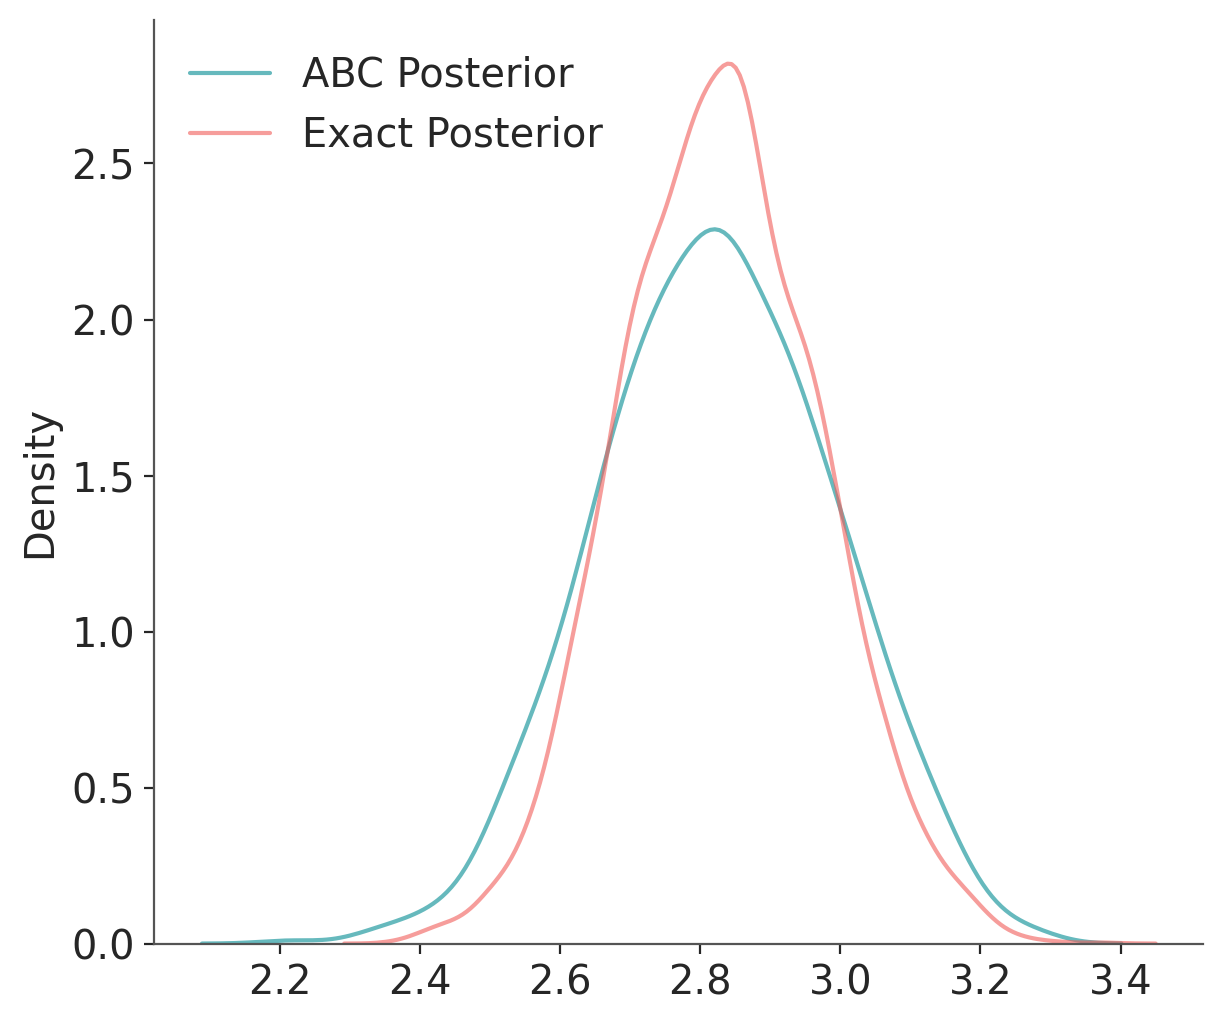

In [9]:
sns.kdeplot(
    posterior_abc_sf.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior",
)
# Ground truth posterior (conjugate normal)
posterior_exact = dist.Normal(observed_y.mean(), 1 / jnp.sqrt(50)).sample(
    jr.key(1), (5000,)
)
posterior_exact = posterior_exact[
    (posterior_exact >= -5) & (posterior_exact <= 5)
]  # Truncate to match uniform prior support
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()

## Rejection (with Wasserstein distance)

Often, sufficient summary statistics are not available. One popular distance metric between the observed and simulated data is the Wasserstein distance:

In [10]:
def wasserstein_distance(a, b):
    from scipy.stats import wasserstein_distance

    return jax.pure_callback(
        lambda a, b: jnp.array([wasserstein_distance(x, b) for x in a]),
        jax.ShapeDtypeStruct((a.shape[0],), jnp.float32),
        a,
        b,
        vmap_method="sequential",
    )

In [11]:
posterior_abc_ws = abc_rejection_sample_stopping(
    key=jr.key(0),  # Set seed for reproducibility
    prior_sample=prior_sample,
    simulator=simulator,
    N=N,
    s_obs=observed_y,  # Use raw observed data
    distance=wasserstein_distance,
    kernel_type="gaussian",
    max_iter=MAX_ITER,
    h_min=0.01,
)

In [12]:
az.summary(posterior_abc_ws)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.855,0.181,2.531,3.193,0.006,0.004,970.0,873.0,NaN


<Axes: ylabel='Density'>

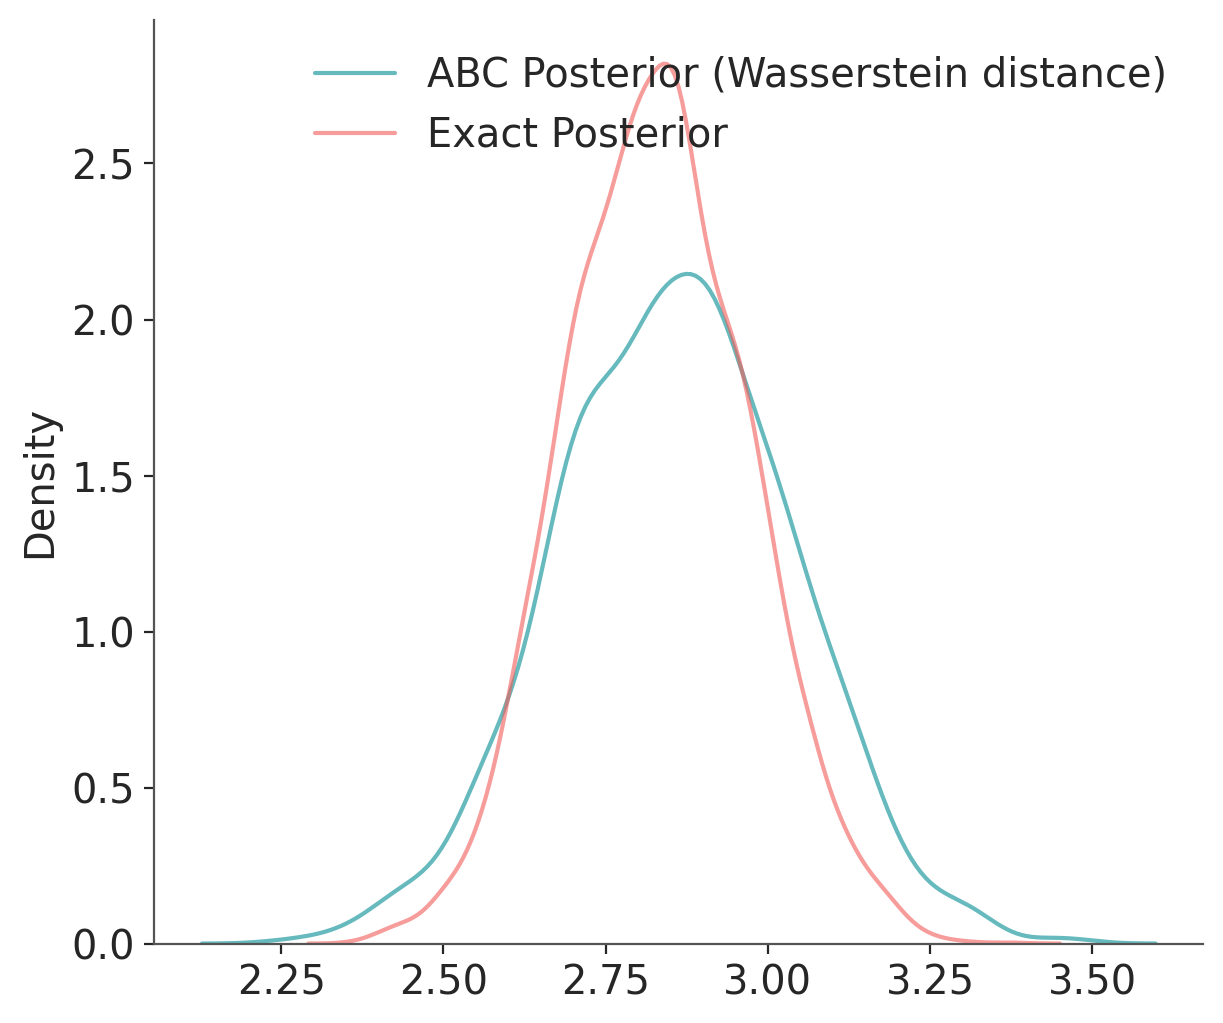

In [13]:
sns.kdeplot(
    posterior_abc_ws.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior (Wasserstein distance)",
)
# Ground truth posterior (conjugate normal)
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()